# Effect of the smoothing factor

In [1]:
import pymultipleis as pym

In [2]:
import numpy as onp
import jax.numpy as jnp

In [3]:
# Load the file containing the frequencies
F_her = jnp.asarray(onp.load('../../../data/her_50/freq_50.npy'), dtype=jnp.float64)
# Load the file containing the admittances (a set of 50 spectra)
Y_her = jnp.asarray(onp.load('../../../data/her_50/Y_50.npy'))


In [4]:
# Define model
def her(p, f):
    w = 2*jnp.pi*f
    s = 1j * w  
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rad = p[3]
    Cad= p[4]
    nad= p[5]
    Rct= p[6]
    Wct=p[7] 
    Zw = Wct/jnp.sqrt(w) * (1-1j)
    Zct   = Rad + Zw  
    Yca=(((s**nad)*Cad) + Rct**-1)
    Z1=(Yca**-1 +Zct)
    Y1=(Z1**-1)
    Ydl= ((s**nh)*Qh)
    Z = (Rs + (Ydl + Y1)**-1) 
    Y = 1/Z
    return jnp.concatenate((Y.real, Y.imag), axis = 0)



In [5]:
p0 = jnp.asarray([4.72774187e+02, 9.70785283e-07, 6.51261304e-01,
             1.04825669e+03, 7.27786796e-07, 8.33955442e-01,
             5.98926963e+04, 2.03231984e+04], dtype = jnp.float64)

bounds = [[1e-3,  1e6], [1e-9, 1e-1], [1e-1, 1], [1e-5, 1e8], [1e-9,  1e-1], [1e-1, 1], [1e-5,  1e8], [1e-5,  1e8]]
smf_modulus = jnp.full((len(p0),),1.0)

1. Fit simultaneous without a smoothing factor of zero


Using initial

Optimization complete
total time is 0:00:14.503258 0.0005054471650576946


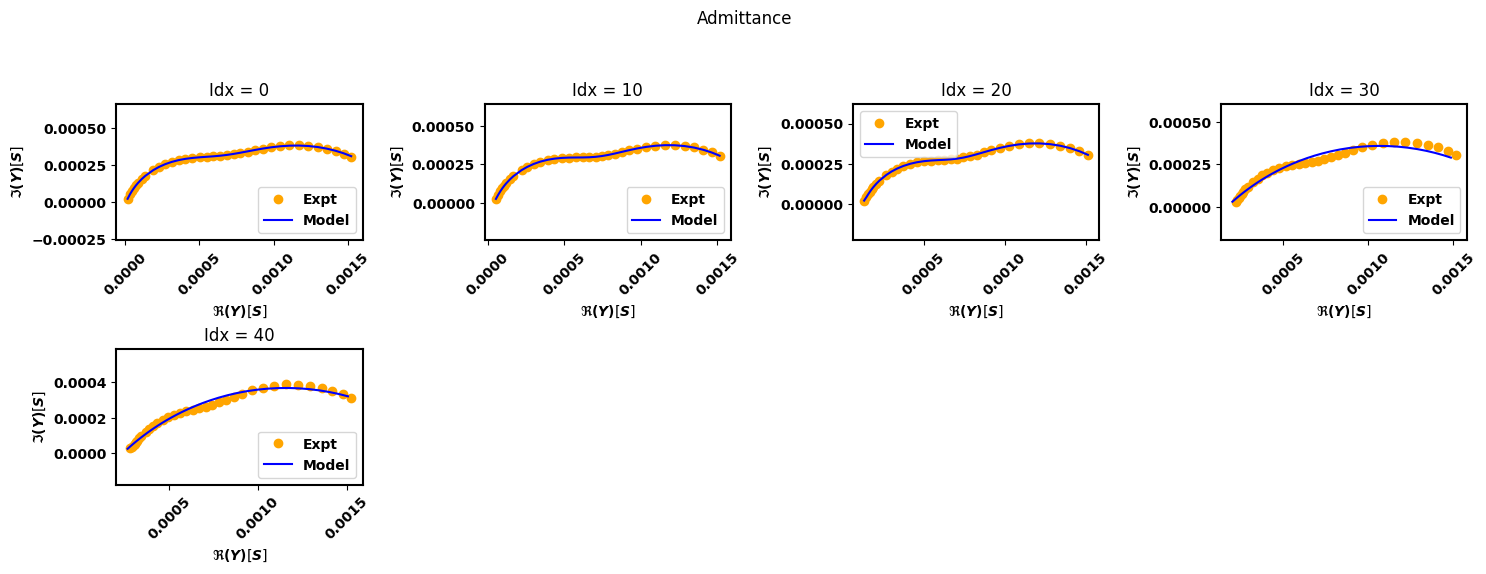

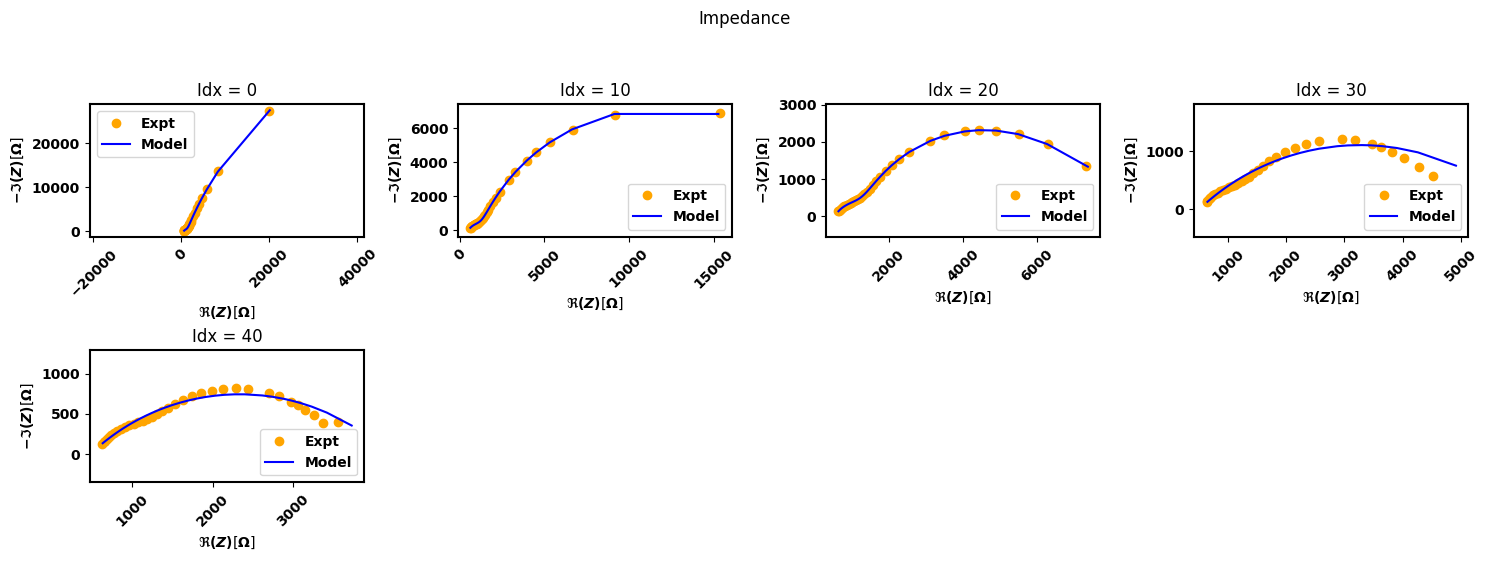

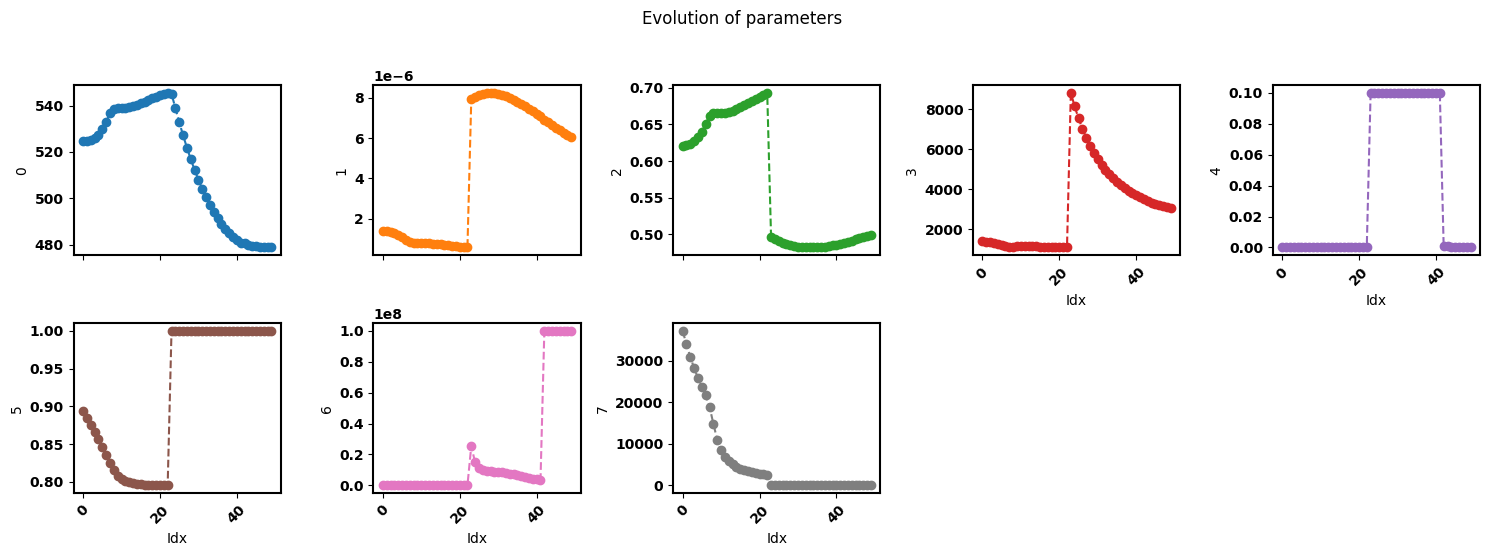

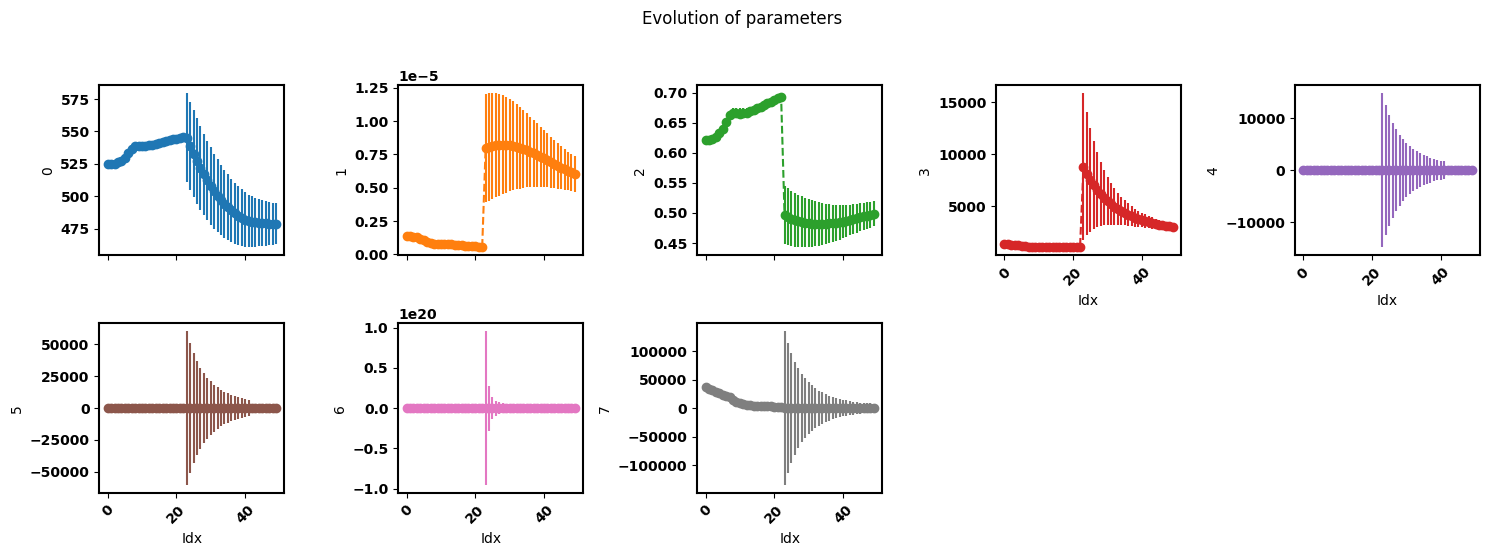

In [6]:
eis_her = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous_zero()
print(chitot)
eis_her.plot_nyquist(10)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)

2. Fit sequential (i.e. fit individual spectra using least squares)


Using initial
fitting spectra 0
fitting spectra 10
fitting spectra 20
fitting spectra 30
fitting spectra 40

Optimization complete
total time is 0:01:03.492508 

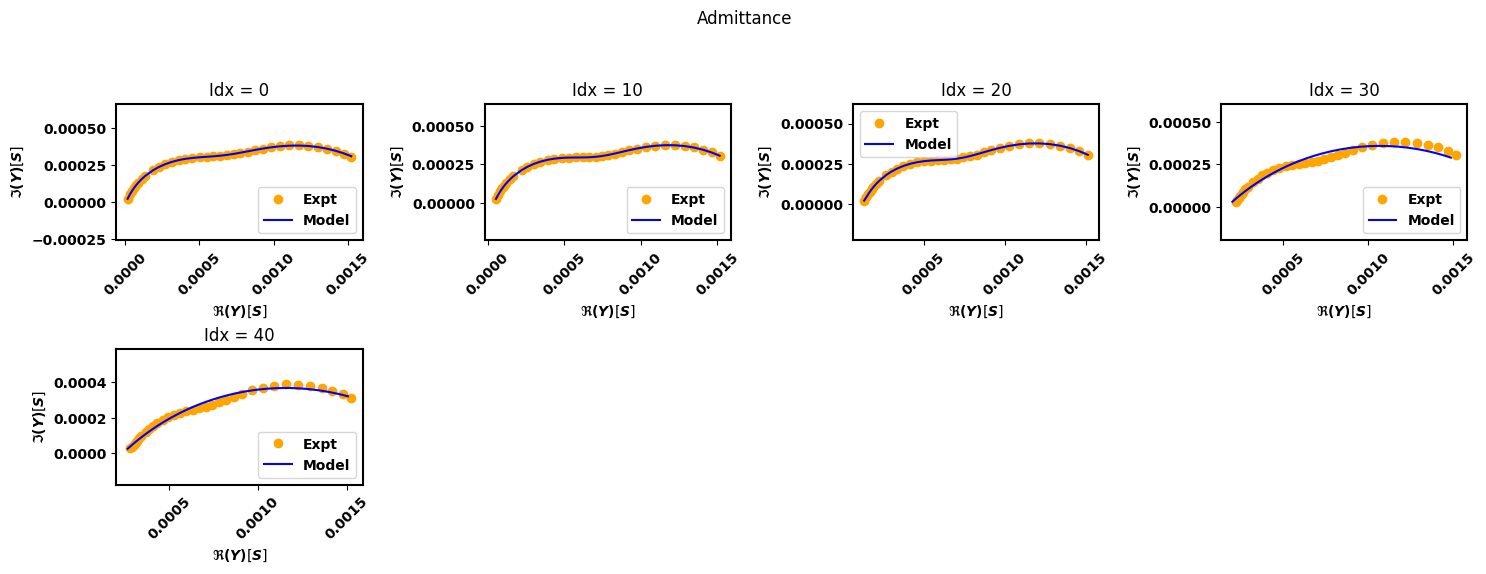

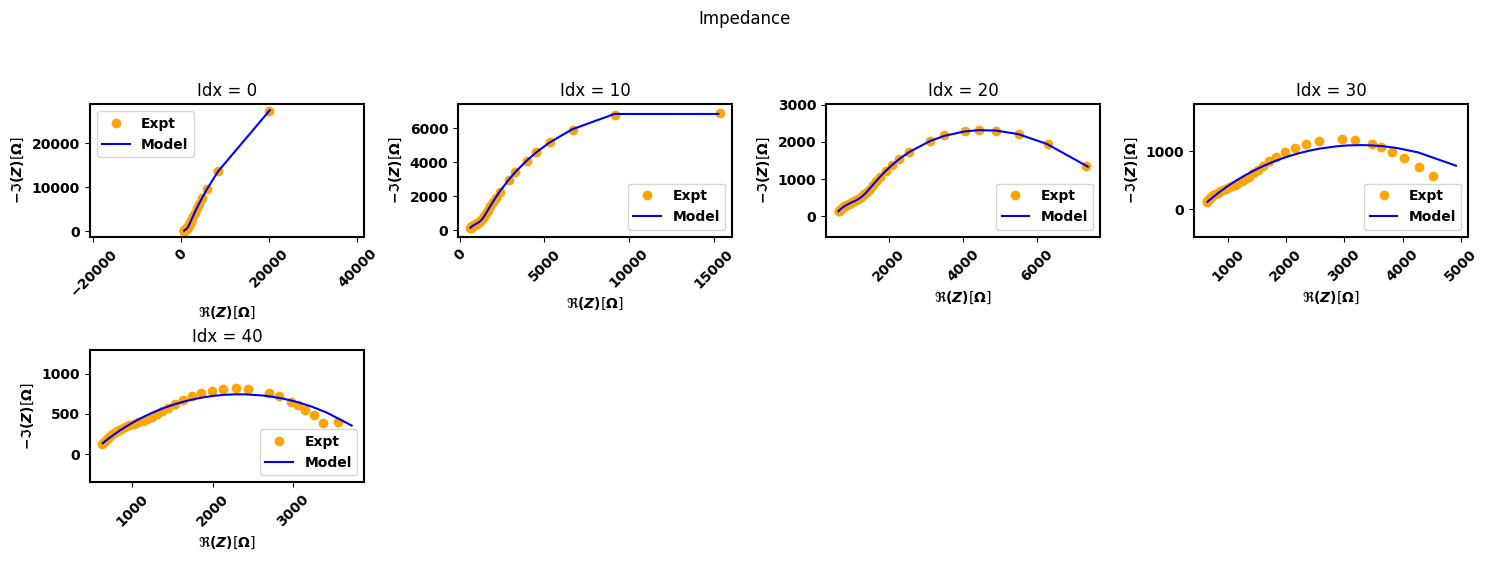

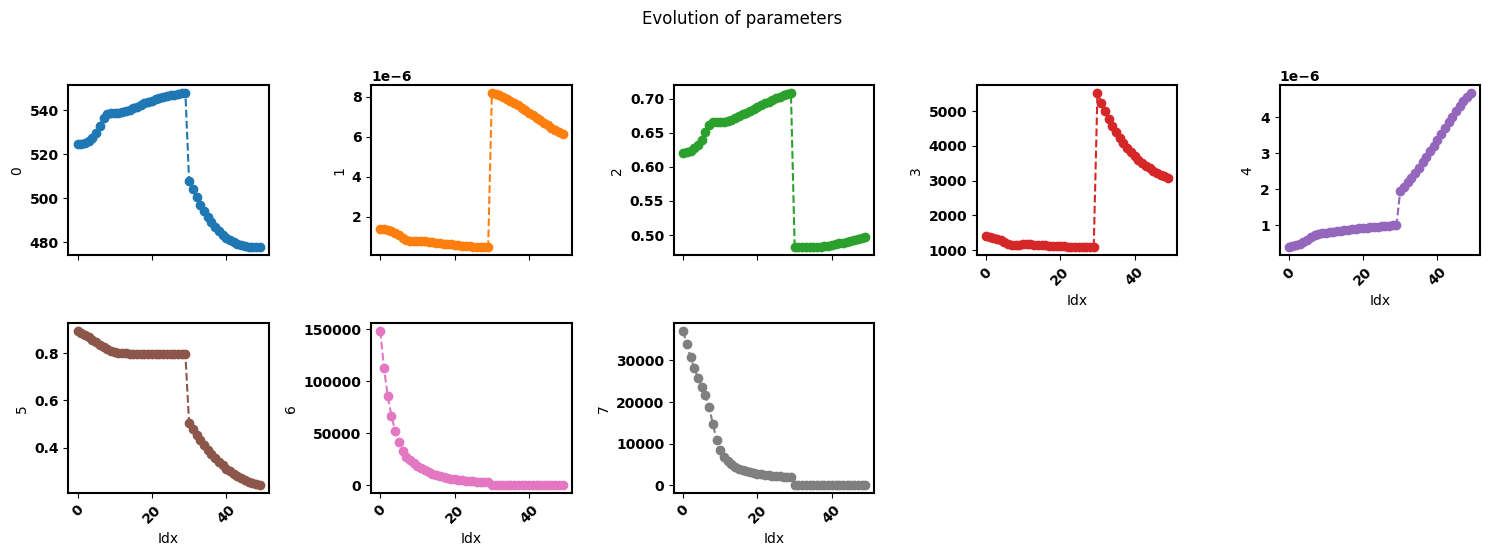

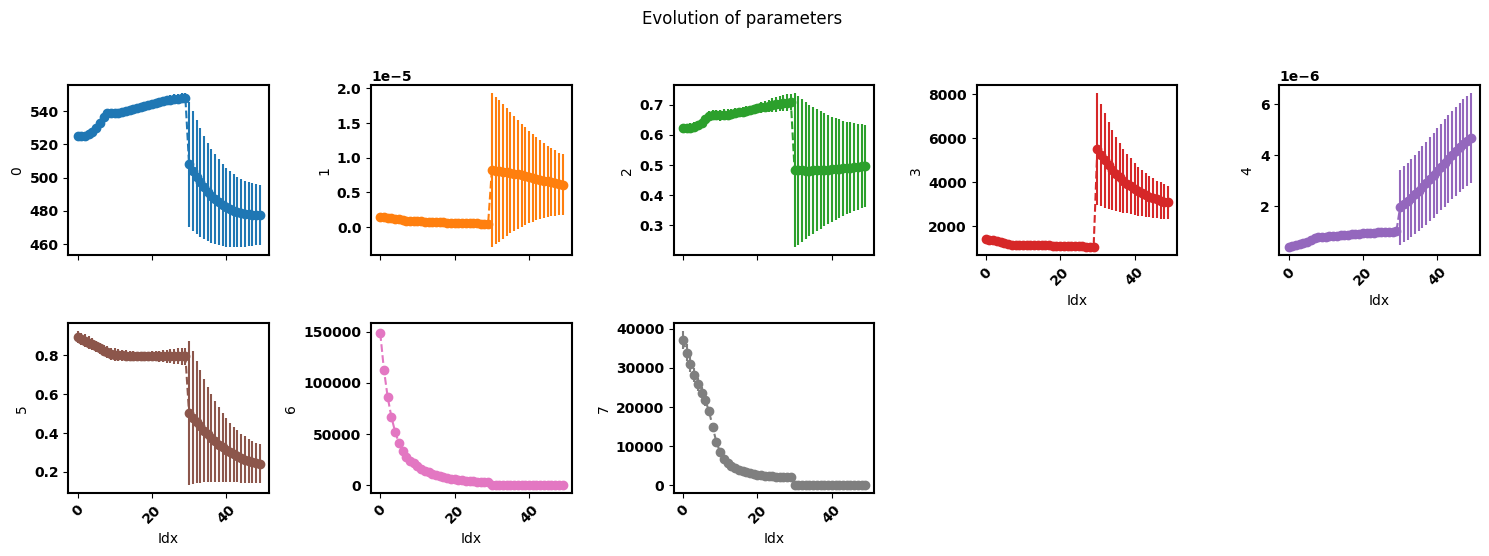

In [7]:
eis_her = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her.fit_sequential()
eis_her.plot_nyquist(10)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)

3. Use a smoothing factor to obtain reasonable initial values before setting the smoothing factor to zero

In [8]:
eis_her = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')

chi=eis_her.compute_total_obj(eis_her.convert_to_internal(p0), eis_her.F, eis_her.Z, eis_her.Zerr_Re, eis_her.Zerr_Im, eis_her.lb_vec, eis_her.ub_vec, eis_her.smf)


Using initial

Optimization complete
total time is 0:00:11.225109 4.669901034830563e-06

Using prefit

Optimization complete
total time is 0:00:05.984875 

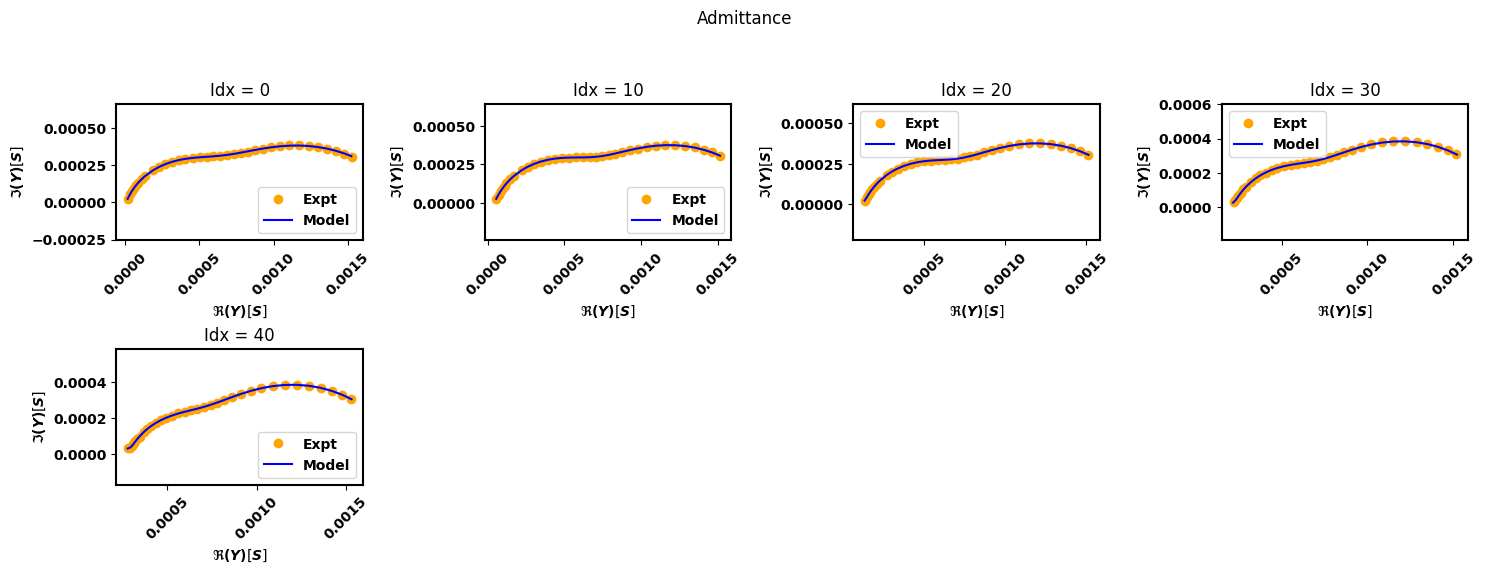

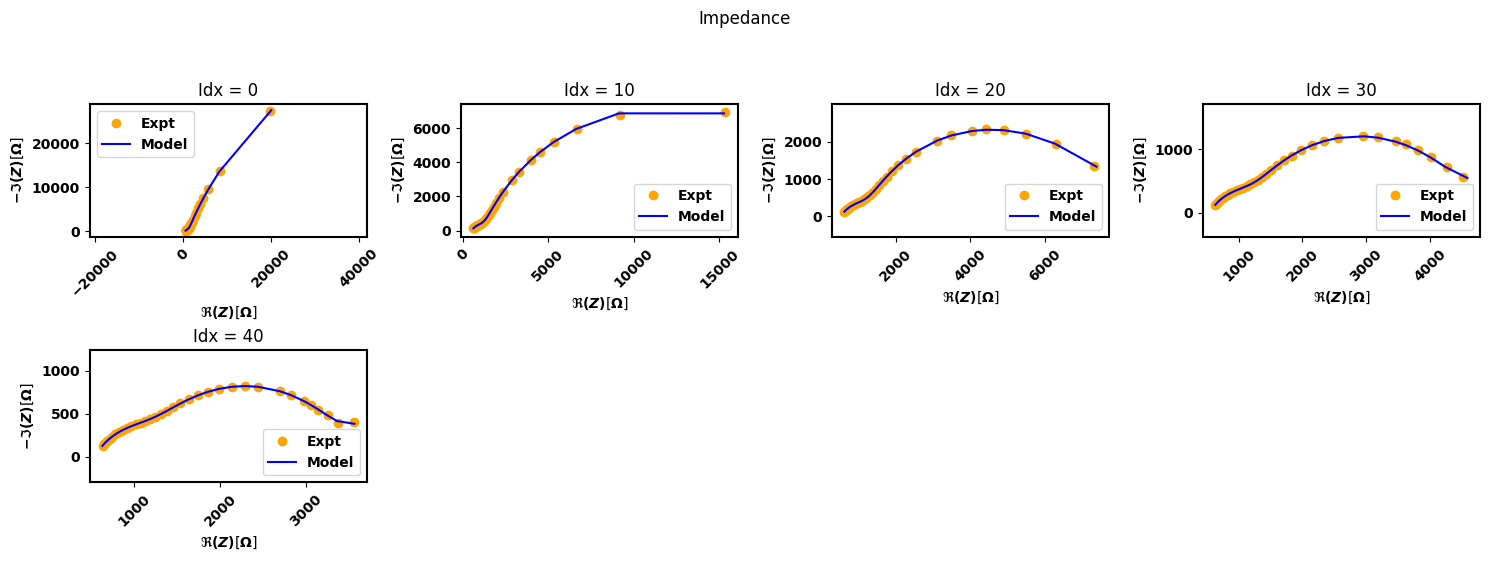

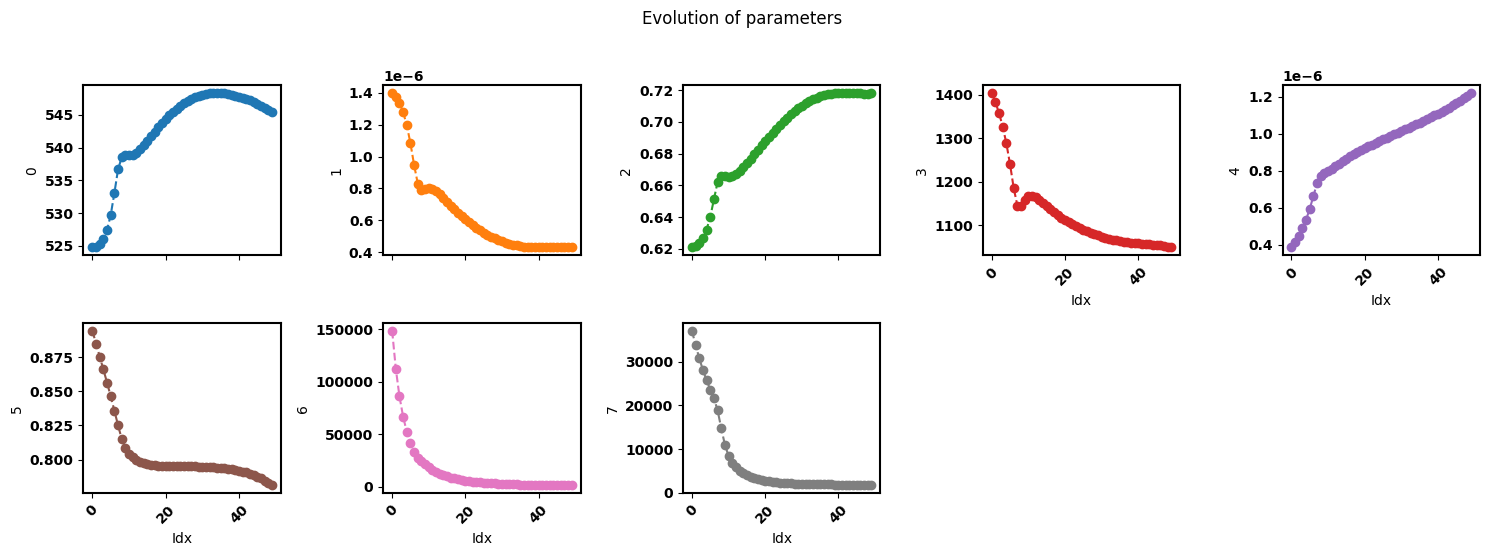

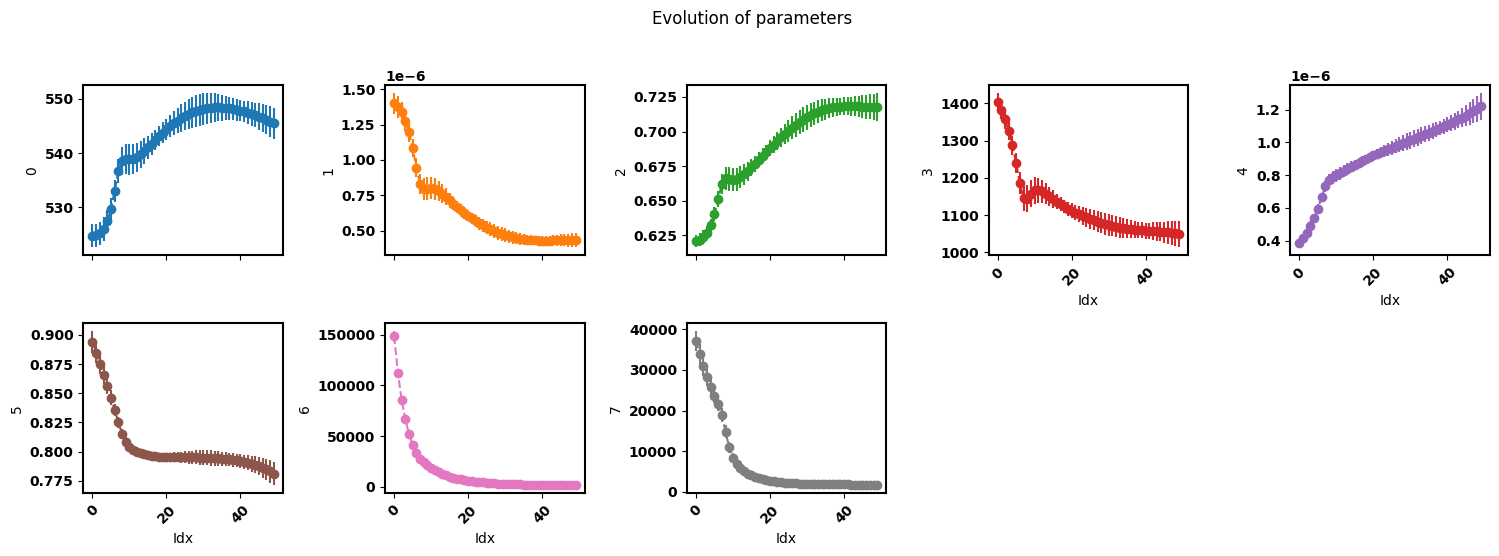

In [9]:
eis_her = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous(method='L-BFGS-B')
print(chisqr)
popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous_zero()
eis_her.plot_nyquist(10)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)

4. Use a smoothing factor to obtain reasonable initial values before fitting each spectra individually


Using prefit

Optimization complete
total time is 0:00:04.744852 
Using prefit
fitting spectra 0
fitting spectra 10
fitting spectra 20
fitting spectra 30
fitting spectra 40

Optimization complete
total time is 0:00:56.096820 

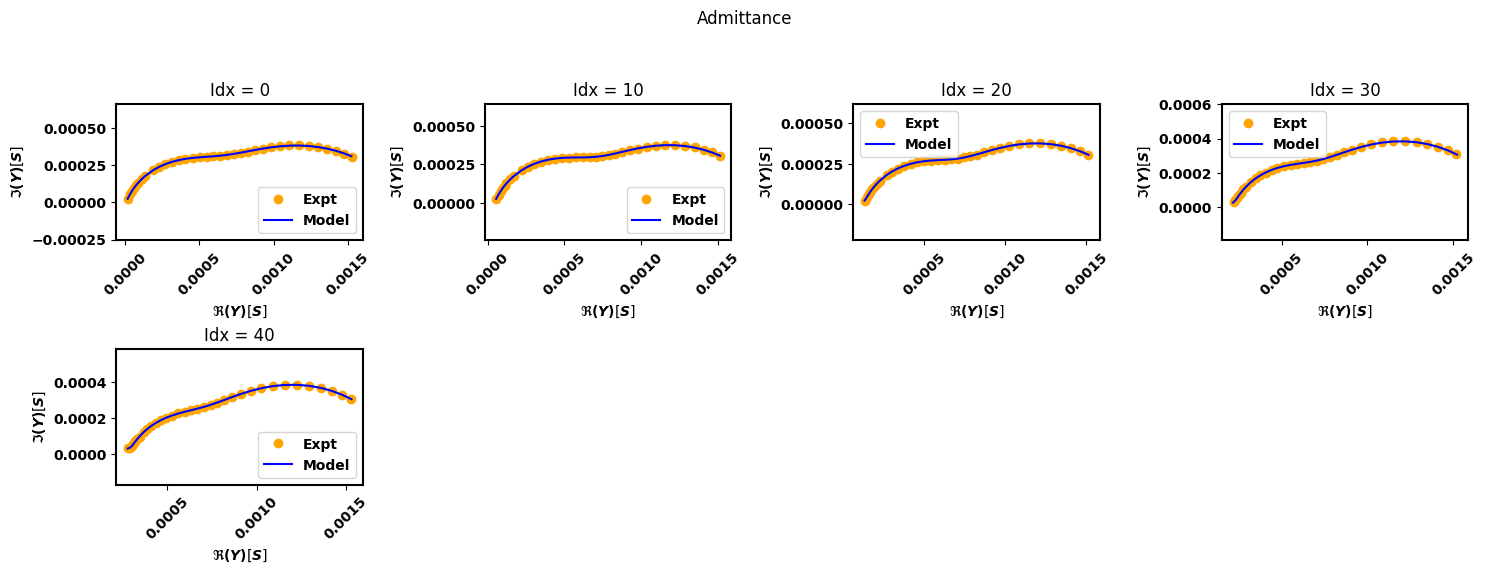

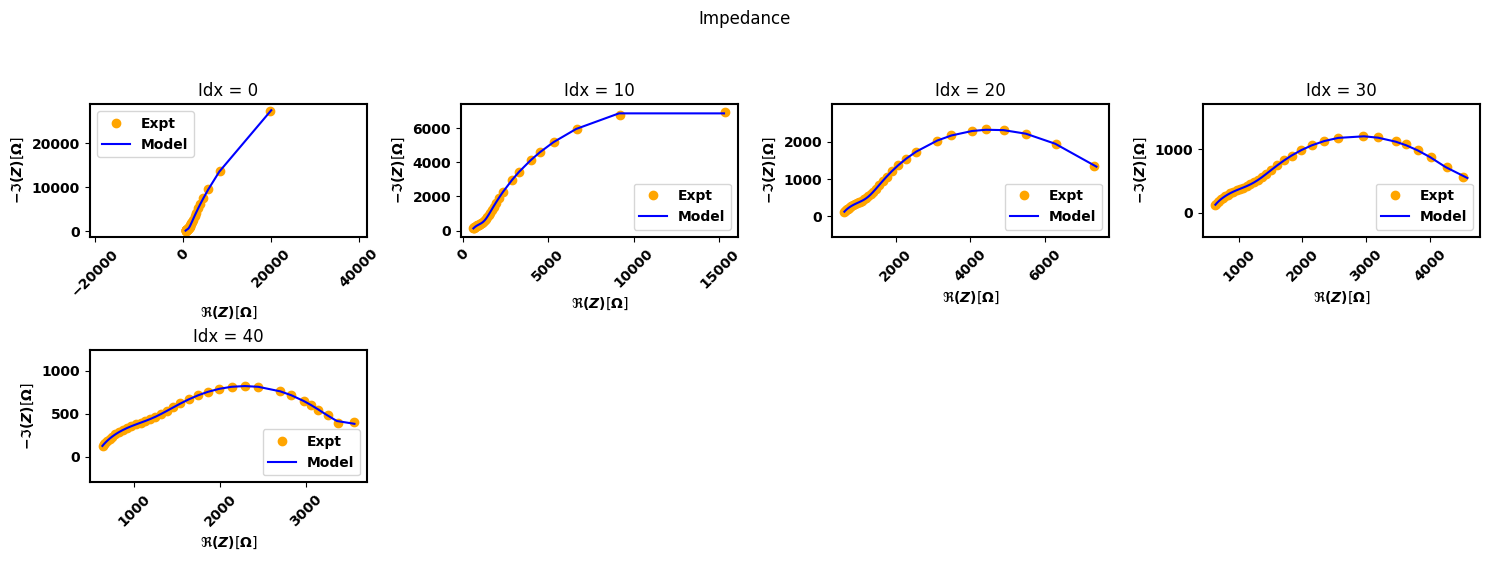

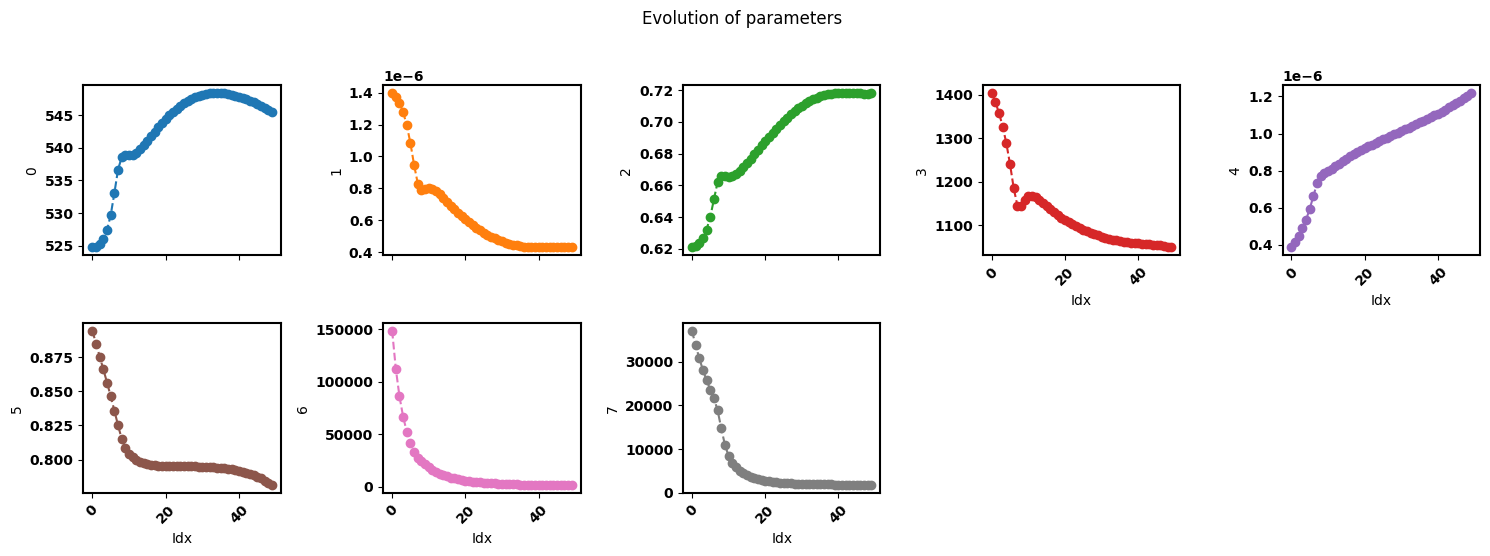

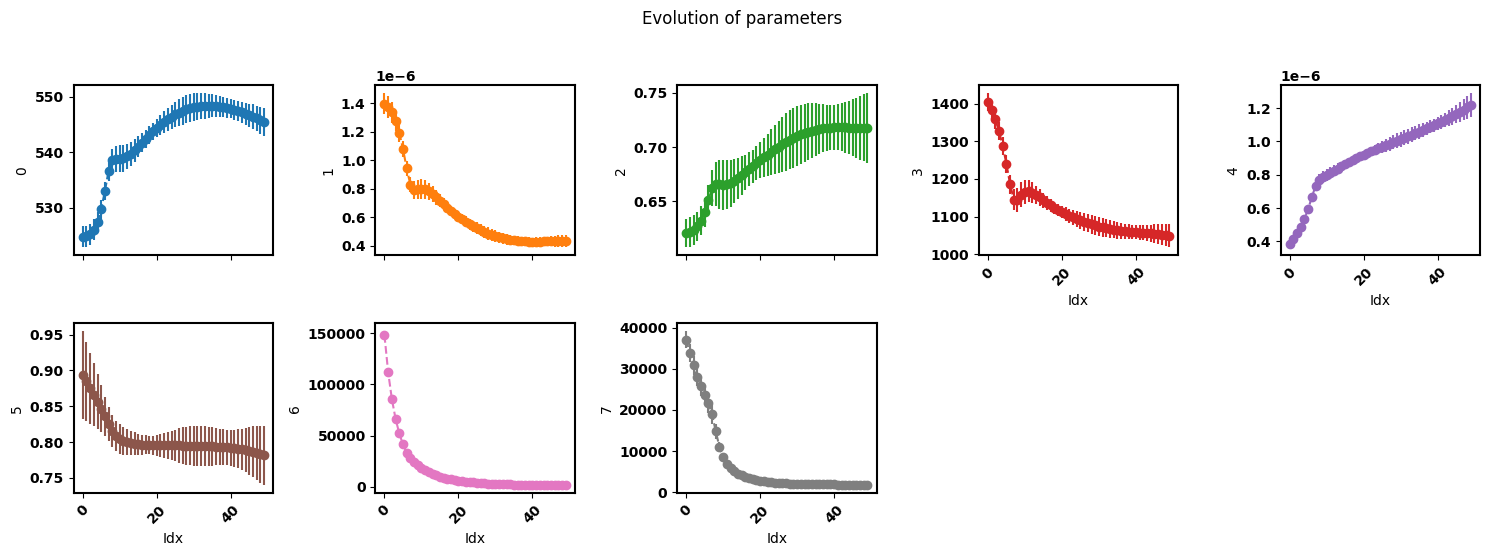

In [10]:
eis_her_simultaneous = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous()
popt, perr, chisqr, chitot, AIC = eis_her.fit_sequential()
eis_her.plot_nyquist(10)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)

## Repeating a single spectra (What to do when you have a single spectra to fit)

In [11]:
Y_her_single_spectra = Y_her[:, 41]
Y_her_single_spectra.shape
# torch.Size([35])

(35,)

In [12]:
Y_her_repeated = jnp.tile(Y_her_single_spectra[:,None], (1, 10))
Y_her_repeated.shape
# torch.Size([35, 10])

(35, 10)


Using initial
0: loss=9.370e-02
10000: loss=4.670e-04
20000: loss=3.162e-06
30000: loss=3.171e-06
40000: loss=3.162e-06
50000: loss=3.162e-06
60000: loss=3.162e-06
70000: loss=3.162e-06
80000: loss=3.162e-06
90000: loss=3.162e-06
Optimization complete
total time is 0:00:52.636309 
Using prefit
fitting spectra 0

Optimization complete
total time is 0:00:11.123443 

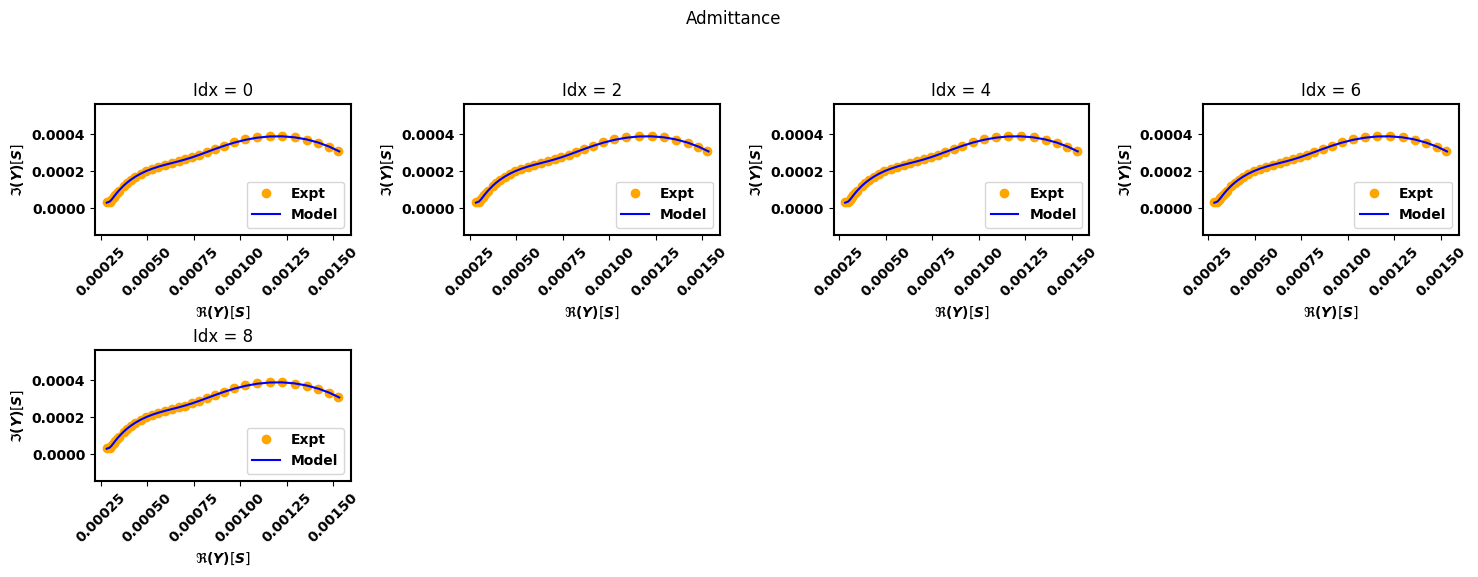

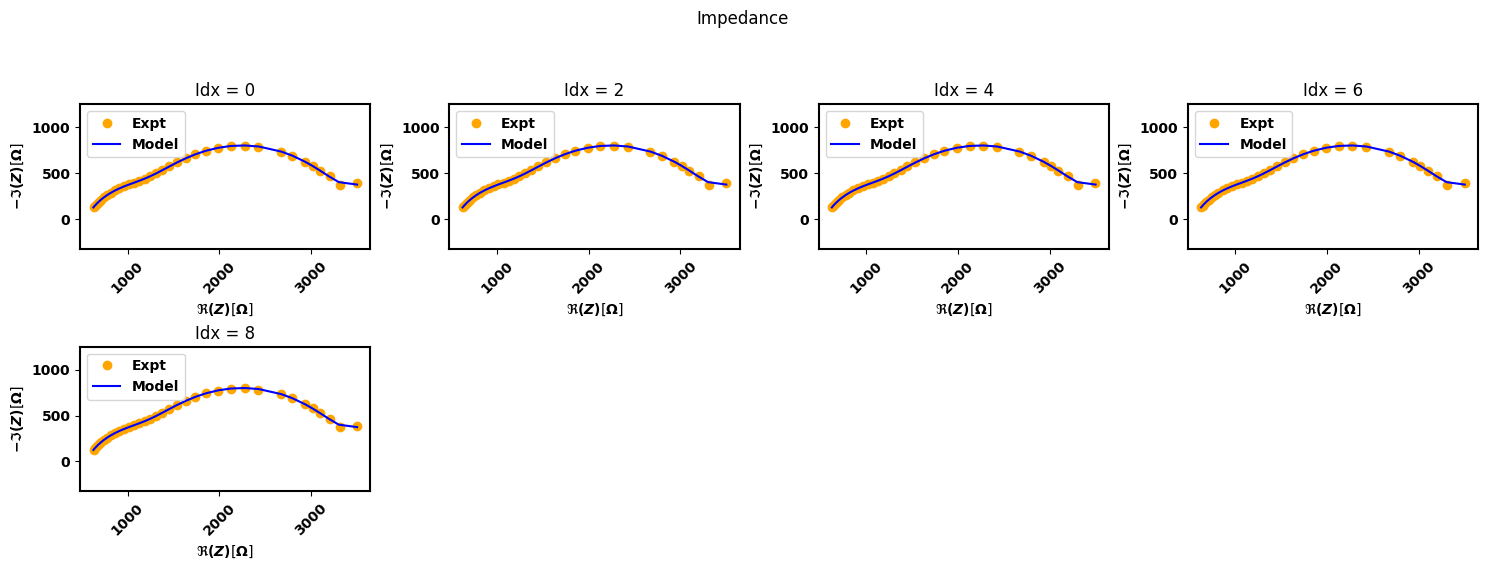

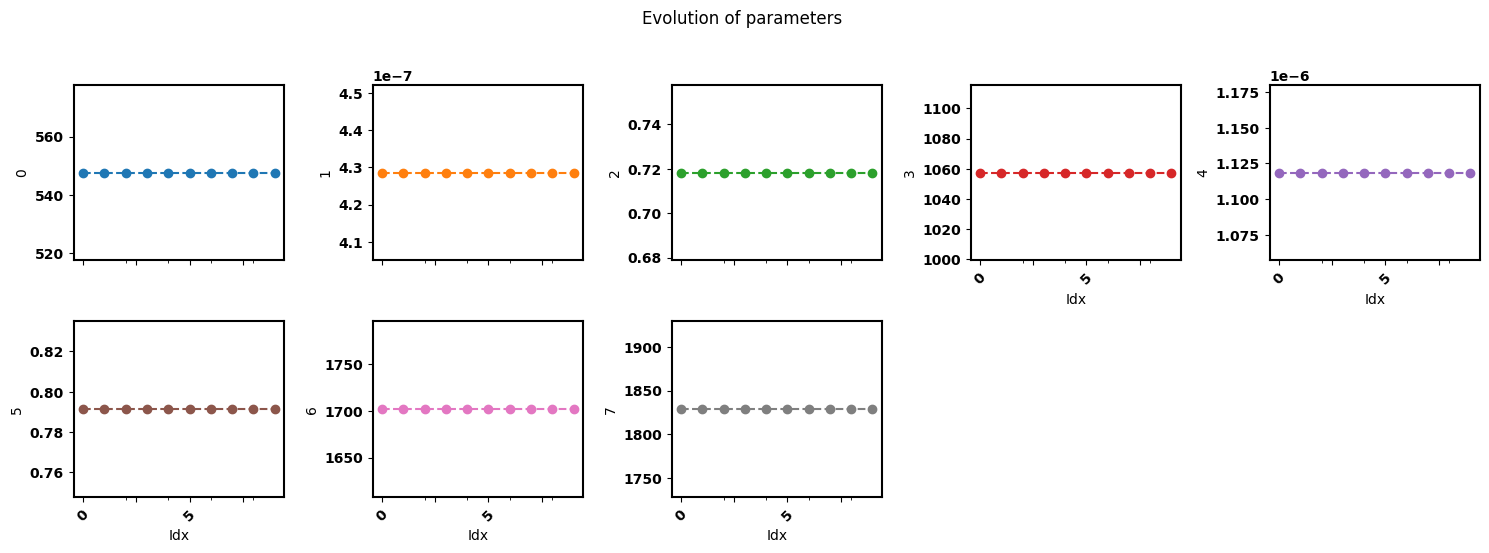

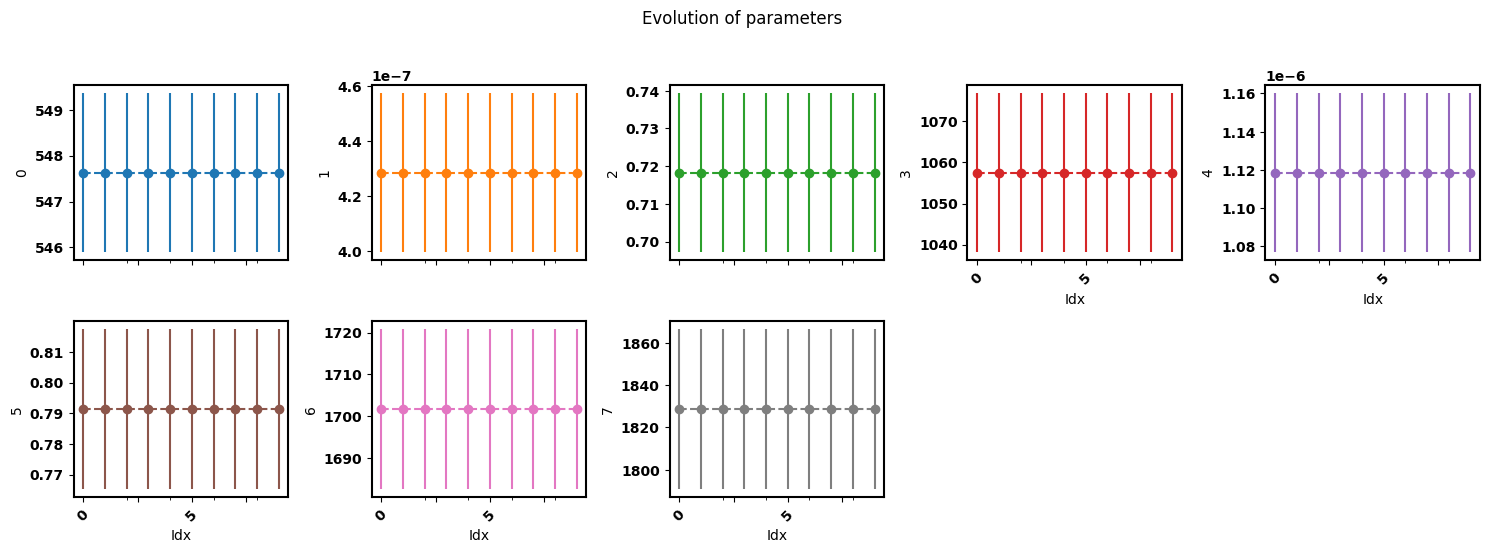

In [13]:
smf = jnp.full((len(p0),), jnp.inf)
eis_her = pym.Multieis(p0, F_her, Y_her_repeated, bounds, smf, her, weight= 'modulus', immittance='admittance')
# popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous()
popt, perr, chisqr, chitot, AIC = eis_her.fit_stochastic()
popt, perr, chisqr, chitot, AIC = eis_her.fit_sequential()
eis_her.plot_nyquist(2)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)